In [1]:
import os
import math
import scipy
import copy
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn import tree             
from scipy.stats import randint
from scipy.stats import loguniform
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from scikitplot.metrics import plot_roc_curve as auc_roc
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score, roc_auc_score, roc_curve, precision_score, recall_score, mean_absolute_error

import geopandas as gpd
import contextily as cx
from geopandas import GeoDataFrame
from geopandas import points_from_xy
import folium

import datetime

# Data Pre-processing

Converting various types and cleaning of data

In [3]:
df = pd.read_csv("data-2.csv", encoding = "utf-8")
df = df.apply(pd.to_numeric, errors='coerce')

df

,advertiser_id,platform,location_at,latitude,longitude,altitude,horizontal_accuracy,vertical_accuracy,speed,publisher_id,model,day
0,23,1,1581128844,40.763606,-73.979611,25.800000,65.0,0.000000,-1.000000,4,16,1
1,29,0,1581982692,40.729590,-73.976893,-15.400000,15.8,2.900000,0.000000,7,2,10
2,46,0,1582224329,40.777012,-73.963351,0.000000,16.7,0.000000,0.000000,4,1,13
3,4,0,1581339516,40.766996,-73.983991,77.500000,17.7,5.099998,0.000000,5,4,3
4,6,1,1581173991,40.739443,-73.988270,12.500000,25.0,0.000000,2.470000,4,16,1
...,...,...,...,...,...,...,...,...,...,...,...,...
58965,1,1,1582089384,40.795873,-73.970972,24.000000,14.5,0.000000,0.000000,4,22,12
58966,37,0,1581540300,40.771864,-73.963210,-14.500000,14.9,0.000000,3.479368,4,8,5
58967,35,1,1581686022,40.751139,-74.002454,18.400000,65.0,0.000000,-1.000000,4,21,7
58968,46,0,1582328188,40.778881,-73.955913,-8.299999,17.6,0.000000,0.000000,4,1,14


In [5]:
df['location_at'] = pd.to_datetime(df['location_at'], unit = 's')

In [6]:
df['hour'] = df['location_at'].dt.hour

In [7]:
df['minute'] = df['location_at'].dt.minute

In [8]:
weekend_days = {1, 2, 8, 9, 15, 16} 
df['weekend'] = df['day'].apply(lambda x: 1 if x in weekend_days else 0)

In [9]:
day_to_weekday = {1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 1, 9: 2, 10: 3, 11: 4, 12: 5, 13: 6, 14: 7}
df['weekday'] = df['day'].map(day_to_weekday)

# Speed Analysis using Clustering
dimensional K means clustering using the KMeans function from sklearn.cluster.

In [10]:
filtered_df= df[df['speed'] != -1]

In [11]:
speed_data = filtered_df['speed'].values.reshape(-1, 1)

kmeans = KMeans(n_clusters=2, random_state=0).fit(speed_data)

filtered_df['cluster'] = kmeans.labels_

print("Centroids of the clusters:", kmeans.cluster_centers_)

c:\Users\myony\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Centroids of the clusters: [[ 0.61055584]
 [13.08378506]]


C:\Users\myony\AppData\Local\Temp\ipykernel_24364\2987335971.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cluster'] = kmeans.labels_


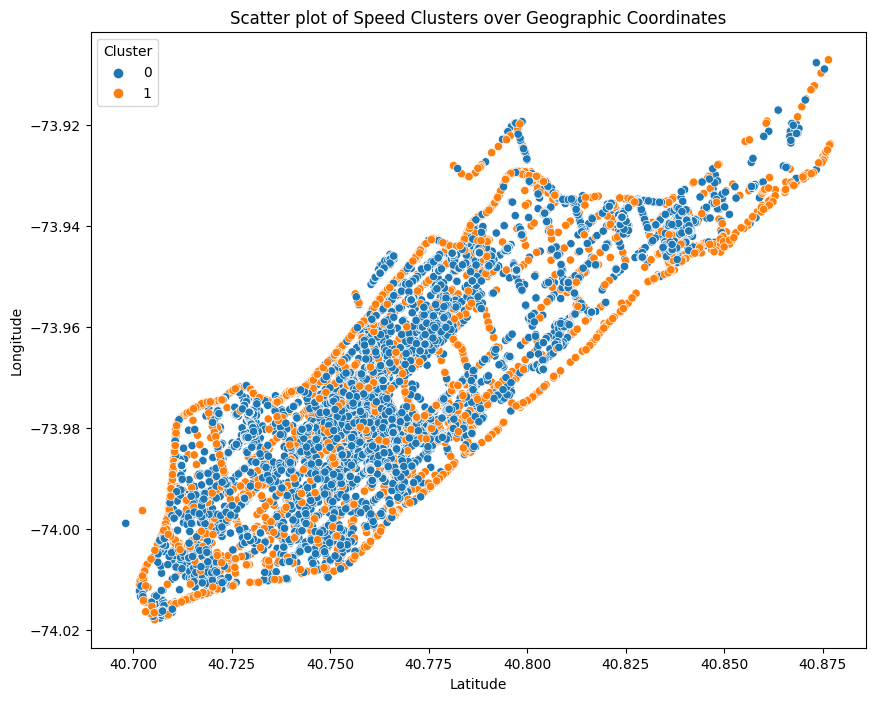

In [12]:
plt.figure(figsize=(10, 8))
scatter_plot = sns.scatterplot(data=filtered_df, x='latitude', y='longitude', hue='cluster')
scatter_plot.set_title('Scatter plot of Speed Clusters over Geographic Coordinates')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.legend(title='Cluster')
plt.show()

The reason for these observations typically relates to urban density, traffic conditions, road types, and time of day:

Slower Speeds: Likely in central urban areas with high pedestrian activity, traffic lights, and congestion.

Faster Speeds: More common on roads that allow for uninterrupted travel at higher speeds, possibly including highways or less congested streets during certain times.


This clustering and mapping effectively highlight how geographic and urban planning factors influence speed behavior in a city like Manhattan

# Platform Prediction Modelling

Simple binary classification ML algorithms to predict the Platform. Recall that the platform can either be o (Android) or 1 (iOS)

In [13]:
X = df[['horizontal_accuracy', 'vertical_accuracy']]
y = df['platform']

In [14]:
np.random.seed(2023)

train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.20)

In [17]:
log_reg = LogisticRegression()
dec_tree = DecisionTreeClassifier()


log_reg.fit(train_X, train_y)
log_reg_pred = log_reg.predict(test_X)


dec_tree.fit(train_X, train_y)
dec_tree_pred = dec_tree.predict(test_X)


def evaluate_model(test_y, predictions):
    acc = accuracy_score(test_y, predictions)
    prec = precision_score(test_y, predictions)
    rec = recall_score(test_y, predictions)
    f1 = f1_score(test_y, predictions)
    auc = roc_auc_score(test_y, predictions)
    return acc, prec, rec, f1, auc


print("Logistic Regression:", evaluate_model(test_y, log_reg_pred))
print("Decision Tree:", evaluate_model(test_y, dec_tree_pred))

Logistic Regression: (0.6499067322367306, 0.6274810537712018, 1.0, 0.7711070458451135, 0.5733622649307708)
Decision Tree: (0.9319993216889944, 0.9505051984185093, 0.9332854061826025, 0.9418165989553106, 0.9317181318989061)


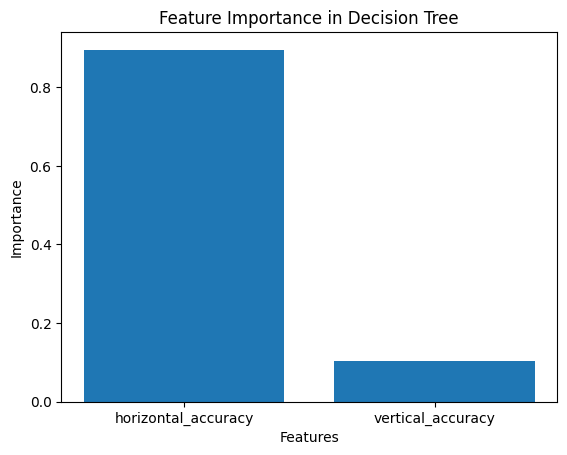

In [16]:
features = ['horizontal_accuracy', 'vertical_accuracy']
importances = dec_tree.feature_importances_
plt.bar(features, importances)
plt.title('Feature Importance in Decision Tree')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.show()

Deciscion Tree Classifier performed better than Logistic Regression model.

horizontal_accuracy is the most important for Decision Tree Classifier.

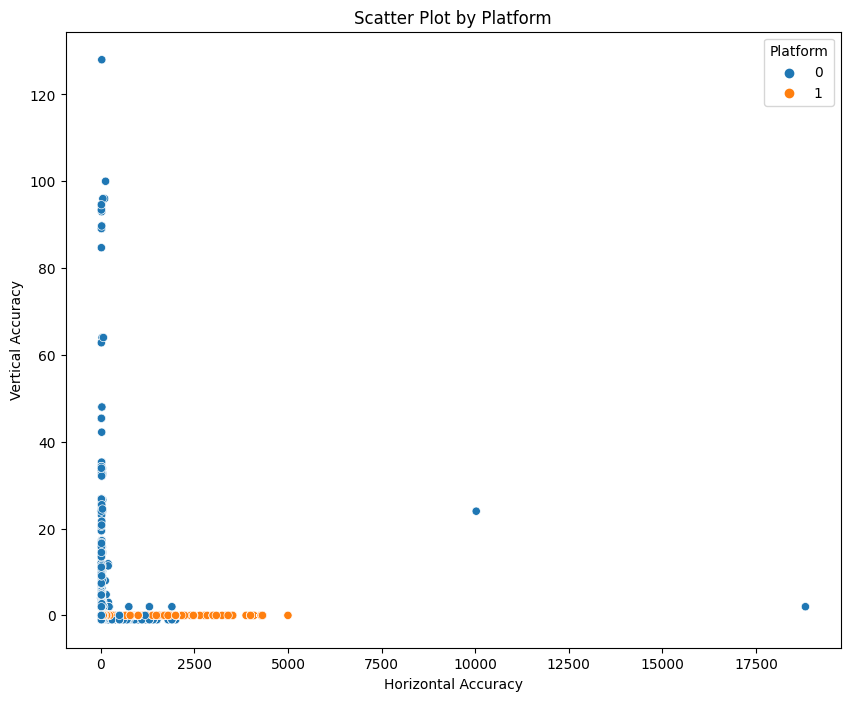

In [18]:
plt.figure(figsize=(10, 8))
scatter_plot = sns.scatterplot(x='horizontal_accuracy', y='vertical_accuracy', hue='platform', data=df)
scatter_plot.set_title('Scatter Plot by Platform')
plt.xlabel('Horizontal Accuracy')
plt.ylabel('Vertical Accuracy')
plt.legend(title='Platform')
plt.show()

There is a dense cluster of points indicates a large number of observations with both low horizontal and vertical accuracy errors, distribution of platforms within this dense region seems to be mixed.

Both platforms are present across a wide range of horizontal accuracies but are more confined in terms of vertical accuracy. iOS devices (platform 1) are generally clustered at lower values of both horizontal and vertical accuracy, whereas Android devices (platform 0) have a more dispersed distribution in horizontal accuracy.

The classes are not linearly separable based on these two features alone, as indicated by the overlap in the dense region. However, there seems to be a slight trend where iOS devices tend to have lower accuracy errors.

# Geospatial Prediction of User Patterns

Using a variety of Machine Learning techniques to predict a user’s geographical coordinates. Developing systematic models trained on 1st 10 days of user patterns and use it to predict the user’s latitude and longitude on days 11-14. This is a type of multi-output regression problem (multi-output as predicting two variables – latitude & longitude- simultaneously; regression because the variables are continuous)

In [19]:
df_ml = df[['advertiser_id', 'latitude', 'longitude', 'altitude', 'speed', 'weekend', 'hour', 'minute', 'weekday','day']]

df_ml.head()

,advertiser_id,latitude,longitude,altitude,speed,weekend,hour,minute,weekday,day
0,23,40.763606,-73.979611,25.8,-1.00,1,2,27,1,1
1,29,40.729590,-73.976893,-15.4,0.00,0,23,38,3,10
2,46,40.777012,-73.963351,0.0,0.00,0,18,45,6,13
3,4,40.766996,-73.983991,77.5,0.00,0,12,58,3,3
4,6,40.739443,-73.988270,12.5,2.47,1,14,59,1,1


In [20]:
train_df = df_ml[df_ml['day'] <= 10]
test_df = df_ml[df_ml['day'] > 10]

In [21]:
train_X = train_df.drop(['latitude', 'longitude'], axis=1)
train_y = train_df[['latitude', 'longitude']]

test_X = test_df.drop(['latitude', 'longitude'], axis=1)
test_y = test_df[['latitude', 'longitude']]

In [67]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

model_ann = Sequential([
    Dense(20, input_dim=train_X.shape[1], activation='relu'),  # One hidden layer with 20 neurons
    Dense(2, activation='linear')  #Output layer with 2 neurons for latitude and longitude
])

model_ann.compile(loss='mean_absolute_error', optimizer='adam')

model_ann.fit(train_X, train_y, batch_size=32, epochs=100, verbose=1)

predictions_ann = model_ann.predict(test_X)

mae_ann = mean_absolute_error(test_y, predictions_ann)
print('Mean Absolute Error - ANN:', mae_ann)

std_latitude = train_y['latitude'].std()
std_longitude = train_y['longitude'].std()
range_latitude = train_y['latitude'].max() - train_y['latitude'].min()
range_longitude = train_y['longitude'].max() - train_y['longitude'].min()

print('Standard Deviation of Latitude:', std_latitude)
print('Standard Deviation of Longitude:', std_longitude)
print('Range of Latitude:', range_latitude)

Epoch 1/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 1s 610us/step - loss: 18.1106
Epoch 2/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 1s 576us/step - loss: 7.3735
Epoch 3/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 1s 616us/step - loss: 5.7445
Epoch 4/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 1s 580us/step - loss: 4.6072
Epoch 5/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 1s 595us/step - loss: 3.6302
Epoch 6/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 1s 576us/step - loss: 2.6778
Epoch 7/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 1s 600us/step - loss: 1.7130
Epoch 8/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 1s 591us/step - loss: 0.7025
Epoch 9/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 1s 577us/step - loss: 0.2126
Epoch 10/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 1s 586us/step - loss: 0.1704
Epoch 11/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 1s 610us/step - loss: 0.1469
Epoch 12/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 1s 588us/step - loss: 0.1310
Epoch 13/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 1s 597us/step - loss: 0.1312
Epoch 14/100
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 1s 604us/step -

The standard deviation of the latitude is approximately 0.0359. The MAE is about twice this value, indicating that on average, the predictions of the ANN are off by an amount roughly equal to twice the standard deviation of the latitude values in the training data. This could suggest moderate prediction errors relative to the latitude's variability.

The standard deviation of the longitude is approximately 0.0207. Here, the MAE is significantly larger than the standard deviation of the longitude, which indicates that the model's predictive accuracy is less precise with respect to longitude than latitude.

The range of latitude, which is the difference between the maximum and minimum latitude, is about 0.1753. Compared to the MAE, the error seems small. This indicates that although the ANN has a certain level of error, the model's predictions are relatively close when considering the entire span of latitude values.

The ANN model seems to be better at predicting latitude than longitude since the MAE is closer to the standard deviation of latitude.
The error magnitude (MAE) is considerably smaller than the range of latitude, suggesting that the model has managed to capture the general pattern in the data.

In [68]:
model_knn = KNeighborsRegressor(n_neighbors=3)
model_knn.fit(train_X, train_y)

predictions_knn = model_knn.predict(test_X)

mae_knn = mean_absolute_error(test_y, predictions_knn)
print('Mean Absolute Error - KNN:', mae_knn)

Mean Absolute Error - KNN: 0.011990273711885319


|KNN MAE is lower than of the Neural Network

The lower MAE indicates that, on average, the KNN model's predictions are closer to the true values of the users' geographic coordinates.

Mean Absolute Error - Decision Tree: 0.006269723531404237


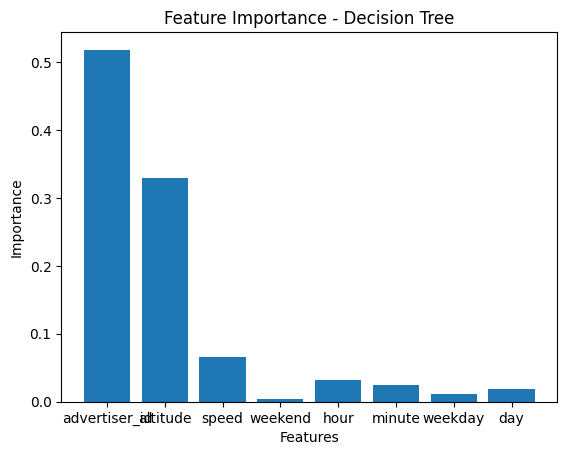

In [69]:
model_dtr = DecisionTreeRegressor()
model_dtr.fit(train_X, train_y)

predictions_dtr = model_dtr.predict(test_X)

mae_dtr = mean_absolute_error(test_y, predictions_dtr)
print('Mean Absolute Error - Decision Tree:', mae_dtr)

importances = model_dtr.feature_importances_
plt.bar(train_X.columns, importances)
plt.title('Feature Importance - Decision Tree')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.show()

Decision Tree Regressor MAE is lowest out of the models.

'advertiser_id' and 'altitude' are the two most significant features

Given that the 'advertiser_id' is the most significant predictor, there might be a concern regarding overfitting to specific user patterns in the training set that won't generalize well to unseen users. This would need to be assessed with additional validation.

In [84]:
random_advertiser = test_df['advertiser_id'].sample(1).iloc[0]

actual_coords = test_df[test_df['advertiser_id'] == random_advertiser][['latitude', 'longitude']]
predicted_coords = predictions_dtr[test_df['advertiser_id'] == random_advertiser]

manhattan_map = folium.Map(location=[actual_coords.iloc[0][0], actual_coords.iloc[0][1]], zoom_start=13)


for idx, row in actual_coords.iterrows():
    folium.CircleMarker(location=[row['latitude'], row['longitude']],
                        color='red',
                        fill=True,
                        fill_color='red').add_to(manhattan_map)


for idx, (lat, lon) in enumerate(predicted_coords):
    folium.CircleMarker(location=[lat, lon],
                        color='blue',
                        fill=True,
                        fill_color='blue').add_to(manhattan_map)

manhattan_map

DecisionTreeRegressor model is capable of capturing the general movement patterns of the user but with varying degrees of accuracy across different areas. The overall proximity of the red and blue points suggests the model is reasonably effective but still leaves room for improvement, especially in reducing the distance between actual and predicted points to enhance the precision of predictions.